#### Invoking a Language Model (LLM)

In [1]:
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

In [2]:
_ = load_dotenv()

In [3]:
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['LANGCHAIN_TRACING_V2'] = "true"

In [4]:
llm = ChatOpenAI(model='gpt-3.5-turbo')

In [9]:
response = llm.invoke("What is Artificial Intelligence?")

print(response.content)

Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning, reasoning, problem-solving, perception, and language processing. AI technologies enable machines to perform tasks that typically require human intelligence, such as visual perception, speech recognition, decision-making, and translation between languages. AI has a wide range of applications in various industries, such as healthcare, finance, transportation, and entertainment, and continues to advance rapidly with the development of new techniques and technologies.


In [11]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

In [13]:
messages = [
    SystemMessage("You are a helpful AI assistance. You will answer complex topics simply"),
    HumanMessage("What is machine learning in two sentences?")
]

response = llm.invoke(messages)

print(response.content)

Machine learning is a type of artificial intelligence that involves teaching machines to learn from data and improve over time without being explicitly programmed for each task. It uses algorithms to analyze and find patterns in data, allowing machines to make predictions or decisions without human intervention.


#### Extending LLMs with Tools

In [6]:
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

In [7]:
eval("1+3")

4

In [8]:
@tool
def calculator(expression:str) -> str:
    """Calculate mathematical expression. Use this for any math calculations."""
    try:
        result = eval(expression)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculation {expression}: {e}"
    
    
search_tool = TavilySearch(max_results=2)

In [31]:
search_tool.invoke("latest news for asia cup?")

{'query': 'latest news for asia cup?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://timesofindia.indiatimes.com/sports/cricket/asia-cup/asia-cup-2025-india-take-on-pakistan-whats-their-head-to-head-record/articleshow/123878121.cms',
   'title': "Asia Cup 2025: India take on Pakistan – What's their head to head ...",
   'content': 'India and Pakistan are set to clash in a highly anticipated Asia Cup match on September 14, 2025, in Dubai. India holds a 10-6 advantage in past',
   'score': 0.60694176,
   'raw_content': None},
  {'url': 'https://www.youtube.com/watch?v=Z38zqZ6iAxc',
   'title': 'India to face Pakistan in high-stakes Asia Cup clash - YouTube',
   'content': 'India to face Pakistan in high-stakes Asia Cup clash | Latest Updates | DD India Live · Comments.',
   'score': 0.54521364,
   'raw_content': None}],
 'response_time': 0.84,
 'request_id': '6692d306-7bad-4e8e-8b60-287edd3fe790'}

In [11]:
tools = [calculator, search_tool]

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [26]:
response = llm_with_tools.invoke("What is 2 + 3 ?")
print("Tool response:")
print(response.content)

Tool response:



In [27]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6oxM0EEhBvfZaSnp5PnJFeNw', 'function': {'arguments': '{"expression":"2 + 3"}', 'name': 'calculator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 1367, 'total_tokens': 1384, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFas3dPfh1MgChJNHXhF2fTphH67U', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--343c9f1c-b2ce-4419-be41-55ae55f5f7b3-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '2 + 3'}, 'id': 'call_6oxM0EEhBvfZaSnp5PnJFeNw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1367, 'output_tokens': 17, 'total_tokens': 1384, 'input_token_details': {'aud

In [28]:
def handle_tool_calls(response, tool_map):
    if not getattr(response, 'tool_calls', None):
        return

    for tool_call in response.tool_calls:
        tool_name = tool_call['name']
        args = tool_call['args']
        tool = tool_map.get(tool_name)
        if tool:
            result = tool.invoke(args)
            print(f"Tool result: {result}")

In [33]:
tool_map = {
    'calculator': calculator,
    'duckduckgo_search': search_tool,
}

def test_llm_tool(query):
    response = llm_with_tools.invoke(query)
    print(response.content)
    handle_tool_calls(response, tool_map)

# Run some queries
test_llm_tool("What's 25 * 4 + 17?")
test_llm_tool("Latest news for asia cup cricket?")


Tool result: The result of 25 * 4 + 17 is 117



#### Building a Basic LangGraph Chatbot

In [37]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph.message import add_messages

In [39]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [ ]:
def chat_node(state: State) -> State:
    response = llm.invoke(state['messages'])
    return {"messages":[response]}

In [41]:
from langgraph.graph import StateGraph, START, END 

In [42]:
graph_builder = StateGraph(State)

graph_builder.add_node("chat", chat_node)

graph_builder.add_edge(START, "chat")
graph_builder.add_edge("chat", END)


graph = graph_builder.compile()

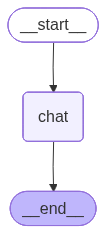

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    
except Exception as e:
    raise

In [48]:
graph.invoke({
    "messages":HumanMessage("Hi")
})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='fdaca91e-ba4d-4c9a-b8de-3a2016d4ab67'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CFhQxgbD8Ecq4MZKdsLqV1cGiVL3r', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--341c7c2b-cb8b-481c-94c9-6f3cc8f903e9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [ ]:
def test_chatbot(message:str) -> str:
    response = graph.invoke({"messages": HumanMessage(content=message)})
    print(f"Assistance: {response['messages'][-1].content}")
    

In [50]:
test_chatbot("Hi, I am pasindu.")
test_chatbot("Do you remember me?")

Assistance Hello Pasindu! How can I assist you today?
Assistance I'm sorry, but I am not capable of remembering individual users. I am a language model AI and do not have the ability to store personal information. How can I assist you today?


#### Adding Memory to the Chatbot

In [53]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [54]:
graph_with_memory = graph_builder.compile(checkpointer=memory)

In [55]:
def chat_with_memory(message: str, thread_id: str):
    config = {"configurable": {"thread_id": thread_id}}
    initial_state = {"messages": [HumanMessage(content=message)]}
    result = graph_with_memory.invoke(initial_state, config)
    print("🤖 Assistant:", result["messages"][-1].content)

# Start a conversation
chat_with_memory("Hi, my name is Pasindu", thread_id="thread-1")
chat_with_memory("What's my name?", thread_id="thread-1")


🤖 Assistant: Hello Pasindu, how can I assist you today?
🤖 Assistant: Your name is Pasindu.


#### LangGraph Agent with Tools

In [9]:
from typing import Annotated, TypedDict 
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [ ]:
from langchain_core.tools import tool
from langchain_tavily import TavilySearch

@tool
def calculator(expression:str) -> str:
    """Calculate mathematical expression. Use this for any math calculations."""
    try:
        result = eval(expression)
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error calculation {expression}: {e}"
    
    
search_tool = TavilySearch(max_results=2)

In [13]:
tools = [calculator, search_tool]

In [14]:
llm = ChatOpenAI(model='gpt-4.1-mini')
llm_with_tools = llm.bind_tools(tools)

In [15]:
def chat_node(state: AgentState) -> AgentState:
    """Answer directly or request tool"""
    system_message = (
        "You are a helpful assistant.\n"
        "Use the `web_search` tool for real‑time facts and `calculator` for maths.\n"
        "Otherwise answer directly."
    )
    
    messages = [
        {"role":"system", "content": system_message},
        *state['messages']
    ]
    
    result = llm_with_tools.invoke(messages)
    
    return {"messages":[result]}

In [16]:
from langgraph.prebuilt import ToolNode 

tool_node = ToolNode(tools)

In [17]:
from typing import Literal

def should_continue(state: AgentState) -> Literal['tool','end']:
    last = state['messages'][-1]
    return 'tool' if getattr(last, 'tool_calls', None) else 'end'

In [18]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [19]:
memory = MemorySaver()

In [27]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("chatbot", chat_node)
graph_builder.add_node('tools_node', tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", should_continue, {'tool':'tools_node', 'end':END})
graph_builder.add_edge("tools_node","chatbot")

graph = graph_builder.compile(checkpointer=memory)

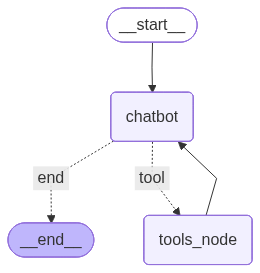

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
    
except Exception as e:
    raise

In [30]:
from langchain_core.messages import HumanMessage

def chat_with_agent(msg: str, thread_id="1"):
    cfg = {"configurable": {"thread_id": thread_id}}
    state = {"messages": [HumanMessage(content=msg)]}
    result = graph.invoke(state, cfg)
    print(result["messages"][-1].content)

chat_with_agent("What's 15% of 240?")
chat_with_agent("Search for recent news about artificial intelligence")

15% of 240 is 36.
Here are some recent news updates about artificial intelligence:

1. Xiaomi has announced a next-generation AI voice model optimized for in-car and smart home experiences. This model features faster response times and can operate offline. You can read more about this on Crescendo.ai: [Latest AI News and Breakthroughs](https://www.crescendo.ai/news/latest-ai-news-and-updates).

2. SoftBank's chief mentioned that Artificial Super Intelligence (ASI) could be here within the next 10 years, emphasizing the rapid advancement in AI. Additionally, Malaysia has launched its first AI-powered bank called Ryt Bank. Google has introduced Veo 3 AI video creation tools. More details are available at ArtificialIntelligence-News.com: [AI News, Analysis & Events](https://www.artificialintelligence-news.com/). 

If you'd like more detailed information on any of these topics, feel free to ask!


In [31]:
chat_with_agent("what Xiaomi has announced?")

Xiaomi has announced a next-generation AI voice model that is optimized for use in in-car and smart home experiences. This new AI voice model features faster response times and has the capability to operate offline, enhancing convenience and functionality in these environments.


#### LangGraph RAG Agent

In [7]:
import os
from pathlib import Path
from typing import List

from langchain_community.document_loaders import (
    PyPDFLoader, Docx2txtLoader, TextLoader, UnstructuredMarkdownLoader
)
from langchain_community.document_loaders.directory import DirectoryLoader
from langchain_core.documents import Document

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

In [2]:
SOURCE_DIR   = Path("docs")          # put your files here
INDEX_DIR    = Path("chroma_db_1")   # will be created if missing
EMBED_MODEL  = "text-embedding-3-small"

In [21]:
# # Load docs (keep only pdf/docx for brevity)
# docs = []
# for f in SOURCE_DIR.glob("*.*"):
#     if f.suffix == ".pdf":
#         docs += PyPDFLoader(str(f)).load()
#     elif f.suffix == ".docx":
#         docs += Docx2txtLoader(str(f)).load()
        
def load_documents(folder_path:str) -> List[Document]:
    """load documents in the folder"""
    documents = []
    for files in Path(folder_path).glob("*.*"):
        if files.suffix == ".pdf":
            loader = PyPDFLoader(str(files))
        elif files.suffix == ".docx":
            loader = Docx2txtLoader(str(files))
        elif files.suffix == ".md":
            loader = UnstructuredMarkdownLoader(str(files))
        elif files.suffix == ".txt":
            loader = TextLoader(str(files))
        else:
            print(f"Unsupported file type: {files}")
            continue
        documents.extend(loader.load())
    return documents   

In [22]:
documents = load_documents(SOURCE_DIR)
print(f"Loaded {len(documents)} from directory: {str(SOURCE_DIR)}")

Loaded 9 from directory: docs


In [23]:
documents

[Document(metadata={'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'creationdate': 'D:20250411184712', 'source': 'docs\\Stock_Market_Performance_2024.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}, page_content='Stock Market Performance in 2024\nU.S. Market Overview\nThe year 2024 was a remarkably strong one for equities, with the U.S. stock market extending the\nrobust gains seen in the prior year. The benchmark S&P 500 index delivered roughly a 25% total\nreturn for 2024 (around +23% in price terms)\n. This marked the second consecutive year of over 20% returns for the S&P 500 - a feat not\nobserved since the late 1990s\n. The tech-heavy Nasdaq Composite outpaced the broader market, jumping nearly 29% for the year\n. In contrast, smaller-cap stocks had more modest performance: the S&P 500 Equal-Weight index\nand the Russell 2000 (small-cap benchmark) each rose about 10-11% in 2024\n. The disparity underscored that 2024\'s rally was not evenly dis

In [24]:
# Split & embed
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

In [25]:
chunks     = text_splitter.split_documents(documents)
print(f"Split the documents in to {len(chunks)} chunks.")

Split the documents in to 24 chunks.


In [29]:
chunks

[Document(metadata={'producer': 'PyFPDF 1.7.2 http://pyfpdf.googlecode.com/', 'creator': 'PyPDF', 'creationdate': 'D:20250411184712', 'source': 'docs\\Stock_Market_Performance_2024.pdf', 'total_pages': 9, 'page': 0, 'page_label': '1'}, page_content='Stock Market Performance in 2024\nU.S. Market Overview\nThe year 2024 was a remarkably strong one for equities, with the U.S. stock market extending the\nrobust gains seen in the prior year. The benchmark S&P 500 index delivered roughly a 25% total\nreturn for 2024 (around +23% in price terms)\n. This marked the second consecutive year of over 20% returns for the S&P 500 - a feat not\nobserved since the late 1990s\n. The tech-heavy Nasdaq Composite outpaced the broader market, jumping nearly 29% for the year\n. In contrast, smaller-cap stocks had more modest performance: the S&P 500 Equal-Weight index\nand the Russell 2000 (small-cap benchmark) each rose about 10-11% in 2024\n. The disparity underscored that 2024\'s rally was not evenly dis

In [ ]:
embeddings = OpenAIEmbeddings(model=EMBED_MODEL)

In [11]:
vectordb = Chroma.from_documents(
    documents         = chunks,
    embedding         = embeddings,
    persist_directory = str(INDEX_DIR),
    collection_name   = "kb_collection",
)

In [13]:
vectordb.persist()
print("✅ Index built →", INDEX_DIR.resolve())

✅ Index built → C:\Users\HP\Desktop\Gen-AI\langgraph_project\research\chroma_db_1


C:\Users\HP\AppData\Local\Temp\ipykernel_18760\4188049943.py:1: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()


In [15]:
from langchain_core.tools import tool

retriever = vectordb.as_retriever(search_kwargs={"k": 2})

@tool
def rag_search_tool(query: str) -> str:
    """Search the knowledge‑base for relevant chunks"""
    results = retriever.invoke(query)
    return "/n/n".join(d.page_content for d in results)

In [28]:
rag_search_tool.invoke("what is the apple stock ending price in 2024?")

"Apple's stock had an outstanding 2024, climbing approximately 36% over the course of the year\n. The iPhone maker's share price reached new all-time highs, ending the year around $252 per\nshare (up from about $185 at the start of 2024). This rally lifted Apple's market capitalization to\nnearly $4 trillion by year-end\n, reaffirming its status as the world's most valuable publicly traded company. Apple's gains were\ndriven by solid demand for its products - the company saw successful launches of the iPhone 15\nseries and other hardware updates - as well as continued growth in high-margin services. The\ncompany also expanded its presence in emerging markets, fueling investor optimism about future\ngrowth. Despite only moderate earnings increases in 2024 (Apple's net income grew in the high\nsingle digits), the stock's rapid appreciation led to an expansion in valuation. By the end of 2024\nApple was trading at about 40 times its trailing earnings\nmacrotrends.net/n/nsingle digits), th

In [16]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(max_results=3, topic="general")

@tool
def web_search_tool(query: str) -> str:
    """Up‑to‑date web info via Tavily"""
    return "/n/n".join(r["content"] for r in tavily.invoke({"query": query})["results"])  # simplified


In [29]:
web_search_tool.invoke("what is the apple stock ending price in 2024?")

"* Trending Sports * Trending Money * Trending Live * Data & Glossary * Trending * Trending Sports * Trending Money * Trending Live * Data & Glossary # The closing price for Apple (AAPL) last year was $249.53, on December 31. It was up 34.5% for the year. The latest price is $233.33. | December 31 2024 | $251.55 | $252.38 | $248.55 | $249.53 | 39,480,700 | Unlock 2x data Daily pricing data for Apple dates back to 12/12/1980, and may be incomplete. * Best return by a mid-cap in the S&P 500 in March 2023 * Best mega-cap stock since 2019? * Best YTD returns in the S&P 500 * See trending StatMuse uses cookies for the best experience./n/n* Money * Trending Sports * Trending Money * Trending Live * Data & Glossary * Money * Trending * Trending Sports * Trending Money * Trending Live * Data & Glossary # The closing price for Apple (AAPL) between 2020 and 2024 was $249.53, on December 31. The latest price is $232.60. | December 2024 | $236.43 | $259.18 | $236.32 | $249.53 | 977,916,100 | | Dec

In [22]:
from typing import Annotated, TypedDict, Literal
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [19]:
class AgentState(State):          # add to previous `State`
    route:    str          # "rag", "answer", "web", "end"
    rag:      str | None   # KB result
    web:      str | None   # web‑search snippets

In [25]:
from pydantic import BaseModel
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv


_ = load_dotenv()

In [26]:
# ── Structured helpers ─────────────────
class RouteDecision(BaseModel):
    route: Literal["rag", "answer", "end"]
    reply: str | None = None

class RagJudge(BaseModel):
    sufficient: bool

router_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).with_structured_output(RouteDecision)
judge_llm  = ChatOpenAI(model="gpt-4.1-mini", temperature=0).with_structured_output(RagJudge)
answer_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

In [30]:
# ── Router ─────────────────────────────
def router_node(state: AgentState) -> AgentState:
    q = state["messages"][-1].content
    decision = router_llm.invoke([
        ("system", "Decide route: rag / answer / end"),
        ("user", q)
    ])
    new_state = {**state, "route": decision.route}
    if decision.route == "end":
        new_state["messages"] += [AIMessage(content=decision.reply or "Hello!")]
    return new_state

In [31]:
# ── RAG lookup ─────────────────────────
def rag_node(state: AgentState) -> AgentState:
    q = state["messages"][-1].content
    chunks = rag_search_tool.invoke(q)
    verdict = judge_llm.invoke([("user", f"Question: {q} Docs: {chunks[:300]}…")])
    return {**state, "rag": chunks, "route": "answer" if verdict.sufficient else "web"}

In [33]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

In [34]:
agent_graph = StateGraph(AgentState)
agent_graph.add_node("router",      router_node)
agent_graph.add_node("rag_lookup",  rag_node)
agent_graph.add_node("web_search",  web_node)
agent_graph.add_node("answer",      answer_node)

agent_graph.set_entry_point("router")
agent_graph.add_conditional_edges("router", from_router,
        {"rag": "rag_lookup", "answer": "answer", "end": END})
agent_graph.add_conditional_edges("rag_lookup", after_rag,
        {"answer": "answer", "web": "web_search"})
agent_graph.add_edge("web_search", "answer")
agent_graph.add_edge("answer", END)

agent = agent_graph.compile(checkpointer=MemorySaver())


NameError: name 'web_node' is not defined